# Homework 2

## FINM 25000 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

## HBS Case

### *ProShares Hedge Replication ETF*

***

# 1. The ProShares ETF Product

**Section 1 is not graded**, and you do not need to submit your answers. But you are encouraged to think about them, and we will discuss them.

## 1. Alternative ETFs

Describe the two types of investments referenced by this term.

## 2. Hedge Funds.


* a. Using just the information in the case, what are two measures by which hedge funds are an attractive investment?


* b. What are the main benefits of investing in hedge funds via an ETF instead of directly?

## 3. The Benchmarks

* a. Explain as simply as possible how HFRI, MLFM, MLFM-ES, and HDG differ in their construction and purpose.


* b. How well does the Merrill Lynch Factor Model (MLFM) track the HFRI?

* c. In which factor does the MLFM have the largest loading? (See a slide in Exhibit 1.)


* d. What are the main concerns you have for how the MLFM attempts to replicate the HFRI?


## 4. The HDG Product

* a. What does ProShares ETF, HDG, attempt to track? Is the tracking error small?

* b. HDG is, by construction, delivering beta for investors. Isn't the point of hedge funds to generate alpha? Then why would HDG be valuable?

* c. The fees of a typical hedge-fund are 2% on total assets plus 20% of excess returns if positive. HDG's expense ratio is roughly 1% on total assets. What would their respective net Sharpe Ratios be, assuming both have a gross excess returns of 10% and volatility of 20%?

***

# 2.  Analyzing the Data

Use the data found on Canvas, in <b>'proshares analysis data.xlsx'</b>. 

It has monthly data on financial indexes and ETFs from `Aug 2011` through `May 2025`.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

# Read in the Excel file with multiple sheets
df = pd.ExcelFile('proshares_analysis_data.xlsx')

# Read each sheet into separate dataframes
hedge_fund_df = pd.read_excel(df, sheet_name='hedge_fund_series')
merrill_factors_df = pd.read_excel(df, sheet_name='merrill_factors')

# Remove the first column (dates) from each dataframe
hedge_fund_df = hedge_fund_df.iloc[:, 1:]
merrill_factors_df = merrill_factors_df.iloc[:, 1:]



## 1. 

For the series in the "hedge fund series" tab, report the following summary statistics:
* mean
* volatility
* Sharpe ratio

Annualize these statistics.

In [17]:
print("Mean:")
print(hedge_fund_df.mean() * 12)
print("Volatility:")
print(hedge_fund_df.std() * np.sqrt(12))
print("Sharpe Ratio:")
print((hedge_fund_df.mean() / hedge_fund_df.std()) * np.sqrt(12))


Mean:
MLEIFCTR Index    0.034616
MLEIFCTX Index    0.032971
HDG US Equity     0.023319
QAI US Equity     0.023463
dtype: float64
Volatility:
MLEIFCTR Index    0.056526
MLEIFCTX Index    0.056382
HDG US Equity     0.058790
QAI US Equity     0.050446
dtype: float64
Sharpe Ratio:
MLEIFCTR Index    0.612388
MLEIFCTX Index    0.584771
HDG US Equity     0.396649
QAI US Equity     0.465101
dtype: float64


## 2.

For the series in the "hedge fund series" tab, calculate the following statistics related to tail-risk.
* Skewness
* Excess Kurtosis (in excess of 3)
* VaR (.05) - the fifth quantile of historic returns
* CVaR (.05) - the mean of the returns at or below the fifth quantile
* Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.

There is no need to annualize any of these statistics.

In [18]:
# Calculate skewness
print("Skewness:")
print(hedge_fund_df.skew())

# Calculate excess kurtosis (kurtosis - 3)
print("\nExcess Kurtosis:")
print(hedge_fund_df.kurtosis() - 3)

# Calculate VaR(0.05)
print("\nVaR(0.05):")
print(hedge_fund_df.quantile(0.05))

# Calculate CVaR(0.05)
def calculate_cvar(series, alpha=0.05):
    var = series.quantile(alpha)
    return series[series <= var].mean()

print("\nCVaR(0.05):")
print(hedge_fund_df.apply(calculate_cvar))

# Calculate maximum drawdown and dates
def calculate_max_drawdown(series):
    cumulative = (1 + series).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdowns = cumulative / rolling_max - 1
    
    max_drawdown = drawdowns.min()
    end_idx = drawdowns.idxmin()
    peak_idx = rolling_max.loc[:end_idx].idxmax()
    recovery_idx = drawdowns.loc[end_idx:][drawdowns.loc[end_idx:] >= 0].index.min()
    
    if pd.isna(recovery_idx):
        recovery_idx = "Not recovered"
    
    return pd.Series({
        'Maximum Drawdown': max_drawdown,
        'Peak Date': peak_idx,
        'Trough Date': end_idx,
        'Recovery Date': recovery_idx
    })

print("\nMaximum Drawdown Analysis:")
print(hedge_fund_df.apply(calculate_max_drawdown))


Skewness:
MLEIFCTR Index   -0.254832
MLEIFCTX Index   -0.240097
HDG US Equity    -0.248623
QAI US Equity    -0.402804
dtype: float64

Excess Kurtosis:
MLEIFCTR Index   -1.401669
MLEIFCTX Index   -1.439492
HDG US Equity    -1.267191
QAI US Equity    -1.459054
dtype: float64

VaR(0.05):
MLEIFCTR Index   -0.028333
MLEIFCTX Index   -0.028351
HDG US Equity    -0.031001
QAI US Equity    -0.018567
Name: 0.05, dtype: float64

CVaR(0.05):
MLEIFCTR Index   -0.035857
MLEIFCTX Index   -0.035816
HDG US Equity    -0.037575
QAI US Equity    -0.032696
dtype: float64

Maximum Drawdown Analysis:
                  MLEIFCTR Index  MLEIFCTX Index  HDG US Equity  QAI US Equity
Maximum Drawdown       -0.124302       -0.124388       -0.14072      -0.137716
Peak Date             118.000000      118.000000            118     118.000000
Trough Date           133.000000      133.000000            133     133.000000
Recovery Date         150.000000      150.000000  Not recovered     150.000000


## 3. 

For the series in the "hedge fund series" tab, run a regression of each against SPY (found in the "merrill factors" tab.) Include an intercept. Report the following regression-based statistics:
* Market Beta
* Treynor Ratio
* Information ratio

Annualize these three statistics as appropriate.

In [20]:
# Get SPY returns from merrill_factors_df
spy_returns = merrill_factors_df['SPY']

# Initialize dictionaries to store results
betas = {}
treynor_ratios = {}
information_ratios = {}

# Calculate annualized risk-free rate
rf_annual = 0.02  # Assuming 2% risk-free rate
rf_monthly = (1 + rf_annual)**(1/12) - 1

# Run regressions and calculate statistics for each hedge fund series
for column in hedge_fund_df.columns:
    # Run regression
    X = sm.add_constant(spy_returns)
    y = hedge_fund_df[column]
    model = sm.OLS(y, X).fit()
    
    # Get beta
    beta = model.params[1]
    betas[column] = beta
    
    # Calculate annualized excess return
    excess_return = (1 + (y.mean() - rf_monthly))**12 - 1
    
    # Calculate Treynor ratio (annualized)
    treynor_ratio = excess_return / beta
    treynor_ratios[column] = treynor_ratio
    
    # Calculate tracking error (annualized)
    tracking_error = np.sqrt(12) * model.resid.std()
    
    # Calculate Information ratio (annualized)
    alpha_annual = (1 + model.params[0])**12 - 1
    information_ratio = alpha_annual / tracking_error
    information_ratios[column] = information_ratio

# Create DataFrame with results
results_df = pd.DataFrame({
    'Market Beta': betas,
    'Treynor Ratio': treynor_ratios,
    'Information Ratio': information_ratios
})

print("Regression Statistics:")
print(results_df)


KeyError: 'SPY'

## 4. 

Discuss the previous statistics, and what they tell us about...

* the differences between SPY and the hedge-fund series?
* which performs better between HDG and QAI.
* whether HDG and the ML series capture the most notable properties of HFRI.

## 5. 

Report the correlation matrix for these assets.
* Show the correlations as a heat map.
* Which series have the highest and lowest correlations?

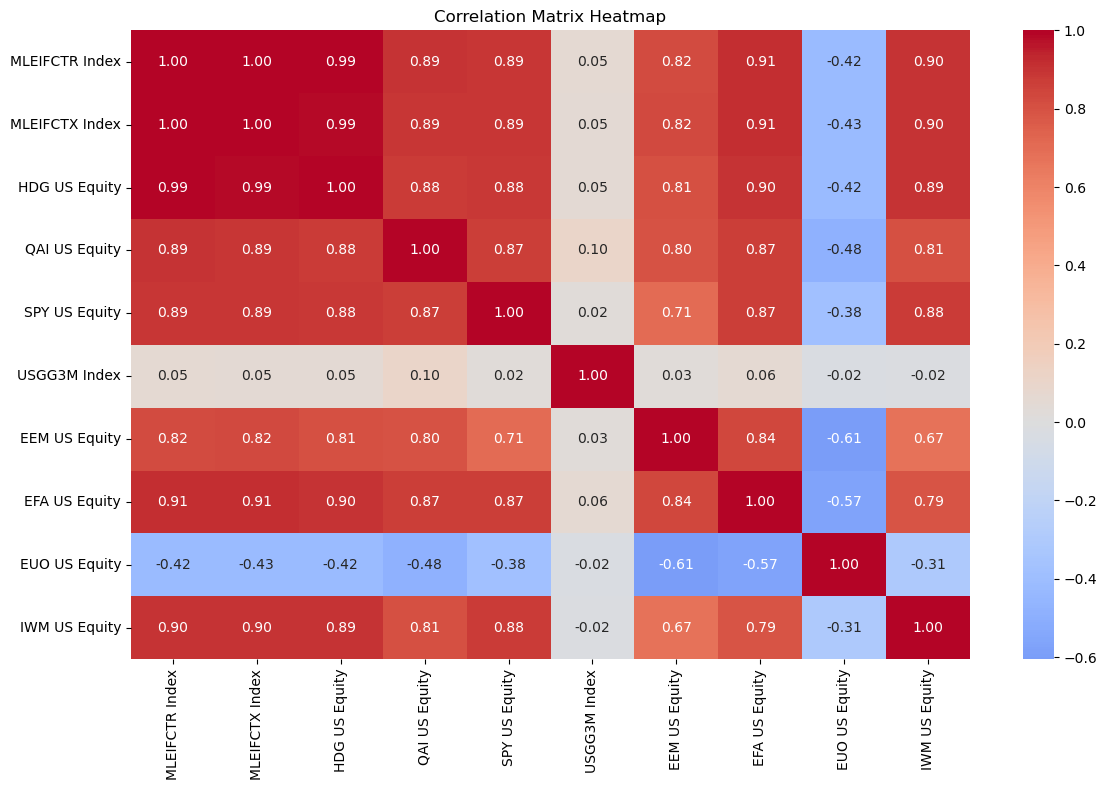


Highest correlation (1.000): MLEIFCTR Index and MLEIFCTX Index
Lowest correlation (-0.605): EEM US Equity and EUO US Equity


In [37]:
# Calculate correlation matrix
all_data = pd.concat([hedge_fund_df, merrill_factors_df], axis=1)
corr_matrix = all_data.corr()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

# Find highest and lowest correlations
# Get upper triangle of correlation matrix excluding diagonal
upper_tri = np.triu(corr_matrix, k=1)
# Convert to 1D array and remove 0s
correlations = upper_tri[upper_tri != 0]

# Find highest correlation pair
max_corr = np.max(correlations)
max_corr_idx = np.where(upper_tri == max_corr)
max_pair = (corr_matrix.index[max_corr_idx[0][0]], corr_matrix.columns[max_corr_idx[1][0]])

# Find lowest correlation pair  
min_corr = np.min(correlations)
min_corr_idx = np.where(upper_tri == min_corr)
min_pair = (corr_matrix.index[min_corr_idx[0][0]], corr_matrix.columns[min_corr_idx[1][0]])

print(f"\nHighest correlation ({max_corr:.3f}): {max_pair[0]} and {max_pair[1]}")
print(f"Lowest correlation ({min_corr:.3f}): {min_pair[0]} and {min_pair[1]}")


## 6.

Replicate HFRI with the six factors listed on the "merrill factors" tab. Include a constant, and run the unrestricted regression,

$\newcommand{\hfri}{\text{hfri}}$
$\newcommand{\merr}{\text{merr}}$

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{\merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\hat{r}^{\hfri}_{t} &= \hat{\alpha}^{\merr} + x_{t}^{\merr}\hat{\beta}^{\merr}
\end{align}$$

Note that the second equation is just our notation for the fitted replication.

a. Report the intercept and betas.

b. Are the betas realistic position sizes, or do they require huge long-short positions?

c. Report the R-squared.

d. Report the volatility of $\epsilon^{\merr}$, the tracking error.

In [45]:
# Multiple regression of HFRI on Merrill factors
X = sm.add_constant(merrill_factors_df)
reg_6 = sm.OLS(hedge_fund_df['HDG US Equity'], X, missing='drop')
results_6 = reg_6.fit()
summary = dict()

# Report the intercept and betas
print("a)")
print(results_6.params)

# Beta check
print("b)")
print("The betas are mostly realistic position sizes, the Gov 3month is large. Alpha is close to 0 though.")

# R-squared calculation
print("c)")
print(results_6.rsquared.round(3))

# Tracking error calculation
print("d)")
print(round(results_6.resid.std(), 3))


a)
const           -0.000962
SPY US Equity    0.018801
USGG3M Index     0.418036
EEM US Equity    0.065508
EFA US Equity    0.145885
EUO US Equity    0.029853
IWM US Equity    0.129971
dtype: float64
b)
The betas are mostly realistic position sizes, the Gov 3month is large. Alpha is close to 0 though.
c)
0.912
d)
0.005


## 7.

Let's examine the replication out-of-sample (OOS).

Starting with $t = 61$ month of the sample, do the following:

* Use the previous 60 months of data to estimate the regression equation. 
This gives time-t estimates of the regression parameters, $\tilde{\alpha}^{\merr}_{t}$ and $\tilde{\beta}^{\merr}_{t}$.

* Use the estimated regression parameters, along with the time-t regressor values, $x^{\merr}_{t}$, calculate the time-t replication value that is, with respect to the regression estimate, built "out-of-sample" (OOS).

$$\hat{r}^{\hfri}_{t} \equiv \tilde{\alpha}^{\merr} + (x_{t}^{\merr})'\tilde{\beta}^{\merr}$$

* Step forward to $t = 62$, and now use $t = 2$ through $t = 61$ for the estimation. Re-run the steps above, and continue this process throughout the data series. Thus, we are running a rolling, 60-month regression for each point-in-time.

How well does the out-of-sample replication perform with respect to the target?

Out-of-sample performance metrics:
Correlation: 0.956
Tracking Error: 0.005
R-squared: 0.912


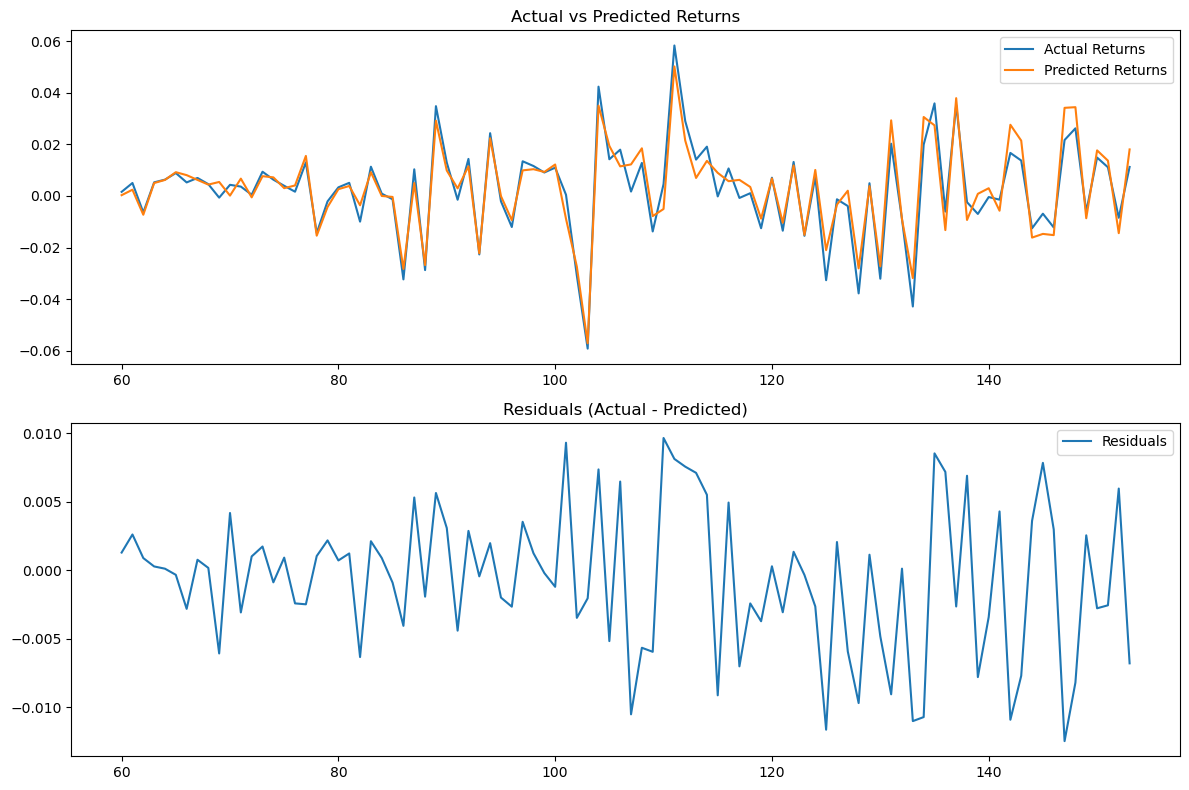

In [ ]:
# Initialize lists to store results
predicted_returns = []
actual_returns = []

# Loop through the data starting at t=60
for t in range(60, len(hedge_fund_df)):
    # Get training data (previous 60 months)
    X_train = merrill_factors_df.iloc[t-60:t]
    y_train = hedge_fund_df['HDG US Equity'].iloc[t-60:t]
    X_train = sm.add_constant(X_train)
    
    # Fit regression model
    model = sm.OLS(y_train, X_train, missing='drop').fit()
    
    # Get test data point (current month)
    X_test = merrill_factors_df.iloc[t:t+1]
    X_test = sm.add_constant(X_test)
    
    # Ensure X_test has the same number of columns as X_train
    if X_test.shape[1] != X_train.shape[1]:
        X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
    
    # Make prediction
    pred = model.predict(X_test)
    actual = hedge_fund_df['HDG US Equity'].iloc[t]
    predicted_returns.append(pred)
    actual_returns.append(actual)

# Calculate performance metrics
predicted_returns = np.array(predicted_returns).flatten()
actual_returns = np.array(actual_returns)
correlation = np.corrcoef(predicted_returns, actual_returns)[0,1]
tracking_error = np.std(predicted_returns - actual_returns)
r_squared = 1 - np.sum((actual_returns - predicted_returns)**2) / np.sum((actual_returns - np.mean(actual_returns))**2)

print(f"Out-of-sample performance metrics:")
print(f"Correlation: {correlation:.3f}")
print(f"Tracking Error: {tracking_error:.3f}")
print(f"R-squared: {r_squared:.3f}")

# Plot actual vs predicted returns
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(hedge_fund_df.index[60:], actual_returns, label='Actual Returns')
plt.plot(hedge_fund_df.index[60:], predicted_returns, label='Predicted Returns')
plt.legend()
plt.title('Actual vs Predicted Returns')

plt.subplot(2,1,2)
plt.plot(hedge_fund_df.index[60:], actual_returns - predicted_returns, label='Residuals')
plt.legend()
plt.title('Residuals (Actual - Predicted)')
plt.tight_layout()
plt.show()


The tracking does pretty well out of sample as the residual is contained roughly within .01 in either direction & the replication has a high correlation to the actual HDG returns with minimal tracking error.

***

# 3.  Extensions
<i>**This section is not graded, and you do not need to submit it.** Still, we may discuss it in class some extensions in class.

For those looking for a challenge, try a few of these.

## 1. 

Merrill constrains the weights of each asset in its replication regression of HFRI. Try constraining your weights by re-doing 2.6.

* Use Non-Negative Least Squares (NNLS) instead of OLS.
* Go further by using a Generalized Linear Model to put separate interval constraints on each beta, rather than simply constraining them to be non-negative.

#### Hints
* Try using LinearRegression in scikit-learn with the parameter `positive=True`. 
* Try using GLM in statsmodels.

## 2. 

Let's decompose a few other targets to see if they behave as their name suggests.

* Regress HEFA on the same style factors used to decompose HFRI. Does HEFA appear to be a currency-hedged version of EFA?

* Decompose TRVCI with the same style factors used to decompose HFRI. The TRVCI Index tracks venture capital funds--in terms of our styles, what best describes venture capital?

* TAIL is an ETF that tracks SPY, but that also buys put options to protect against market downturns. Calculate the statistics in questions 2.1-2.3 for TAIL. Does it seem to behave as indicated by this description? That is, does it have high correlation to SPY while delivering lower tail risk?

## 3. 

The ProShares case introduces Levered ETFs. ProShares made much of its name originally through levered, or "geared" ETFs.

Explain conceptually why Levered ETFs may track their index well for a given day but diverge over time. How is this exacerbated in volatile periods like 2008?

## 4.

Analyze SPXU and UPRO relative to SPY.
- SPXU is ProShares -3x SPX ETF.
- UPRO is ProShres +3x SPX ETF.

Questions:
* Analyze them with the statistics from 2.1-2.3. 

* Do these two ETFs seem to live up to their names?

* Plot the cumulative returns of both these ETFs along with SPY.

* What do you conclude about levered ETFs?

## 5.

In `Section 2`, we estimated the replications using an intercept. Try the full-sample estimation, but this time without an intercept.

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\check{r}^{\hfri}_{t} &= \check{\alpha}^{\merr} + x_{t}^{\merr}\check{\beta}^{\merr}
\end{align}$$

Report

* the regression beta. How does it compare to the estimated beta with an intercept, $\hat{\beta}^{\merr}$?

* the mean of the fitted value, $\check{r}^{\hfri}_{t}$. How does it compare to the mean of the HFRI?

* the correlations of the fitted values, $\check{r}^{\hfri}_{t}$ to the HFRI. How does the correlation compare to that of the fitted values with an intercept, $\hat{r}^{\hfri}_{t}$

Do you think Merrill and ProShares fit their replicators with an intercept or not?

***